# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
!pip install smdebug
!pip install torchvision torch --no-cache-dir
!pip install -U sagemaker

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
import csv
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
import IPython
from jinja2.utils import markupsafe
from markupsafe import Markup
markupsafe.Markup()
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import time
from IPython import display
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

[2022-10-03 13:45:43.448 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:3250 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

dog breed classification dataset is used in this project. It contains 133 dog breeds divided into training, testing and validation.

In [3]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [4]:
session = sagemaker.Session()
bucket= session.default_bucket()
print("Bucket: {}".format(bucket))
region = session.boto_region_name
print("Region: {}".format(region))
role = sagemaker.get_execution_role()
print("Role: {}".format(role))

Bucket: sagemaker-us-east-1-733988231415
Region: us-east-1
Role: arn:aws:iam::733988231415:role/service-role/AmazonSageMaker-ExecutionRole-20220929T154778


In [5]:
# Metadata creation function

def metadata(database_path):
    with open(os.path.join(database_path, 'meta.csv'), 'w', encoding='UTF8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Filename'])
        for root, dirs, images in os.walk(database_path):
            images.sort()
            for image in images:
                if image.lower().endswith('.jpg'):
                    classification_id = int(root.split("/")[2].split(".")[0])-1
                    rel_path = os.path.join(root, image)
                    row = [classification_id, rel_path]
                    writer.writerow(row)
    print('Metadata created:', os.path.join(database_path, 'meta.csv'))
                    
metadata('dogImages/train')
metadata('dogImages/test')
metadata('dogImages/valid')

Metadata created: dogImages/train/meta.csv
Metadata created: dogImages/test/meta.csv
Metadata created: dogImages/valid/meta.csv


In [6]:
# Labeling

database = 'dogImages'

def labels(database):
    output_filename = os.path.join(database, 'labels.csv')
    with open(output_filename, 'w', encoding='UTF8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Breed'])
        for root, dirs, images in os.walk(os.path.join(database, 'test')):
            dirs.sort()
            for directories in dirs:
                dir_name = directories.split(".")
                if (len(dir_name) == 2 and len(dir_name[0])>0):
                    dir_name[0] = int(dir_name[0]) - 1
                    writer.writerow(dir_name)
            break
    print('Labels output', output_filename)
    
labels(database)

Labels output dogImages/labels.csv


In [7]:
# checking dataset

labels_data = pd.read_csv('dogImages/labels.csv')
test_meta = pd.read_csv('dogImages/test/meta.csv')
valid_meta = pd.read_csv('dogImages/valid/meta.csv')
train_meta = pd.read_csv('dogImages/train/meta.csv')

print('Total categories: %d' % len(labels_data))
print('Total images: %s' % str(len(test_meta)+len(valid_meta)+len(train_meta)))
print('Training images: %d' % len(train_meta))
print('Validation images: %d' % len(valid_meta))
print('Test images: %d'% len(test_meta))

Total categories: 133
Total images: 8355
Training images: 6680
Validation images: 837
Test images: 838


In [8]:
# Test HPO loader

class BreedDataset(Dataset):
    def __init__(self, annotations, base_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations)
        self.base_dir = base_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image_path = os.path.join(self.base_dir, self.img_labels.iloc[idx, 1])
        image = read_image(image_path)
        label = int(self.img_labels.iloc[idx, 0])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature shape: torch.Size([64, 3, 224, 224])
Labels shape: torch.Size([64])


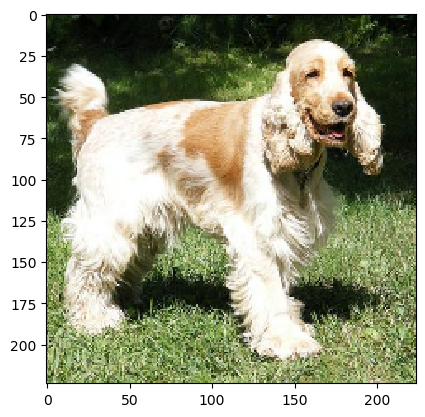

Label: 60


In [9]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image_transform = transforms.Compose([
    transforms.Resize([256, ]),
    transforms.CenterCrop(224),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=mean, std=std)])
training_data = BreedDataset(annotations = 'dogImages/train/meta.csv', base_dir = '.', transform = image_transform)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature shape: {train_features.size()}")
print(f"Labels shape: {train_labels.size()}")
img = train_features[0].squeeze().numpy().transpose(1,2,0)
label = train_labels[0]
plt.imshow(img*std+mean)
plt.show()
print(f"Label: {label}")

In [10]:
# Upload to S3

os.environ["DATABASE_PATH"] = "s3://"+ bucket+ "/dogImages/"
!aws s3 cp dogImages ${DATABASE_PATH} --recursive

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [11]:
#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": sagemaker.tuner.ContinuousParameter(0.001, 0.1),
    "batch-size": sagemaker.tuner.CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [12]:
# Test hpo.py

! python hpo.py

Traceback (most recent call last):
  File "hpo.py", line 223, in <module>
    parser.add_argument('--data_path', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
  File "/opt/conda/lib/python3.7/os.py", line 681, in __getitem__
    raise KeyError(key) from None
KeyError: 'SM_CHANNEL_TRAINING'


In [13]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.2xlarge"
)

tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=8,
    max_parallel_jobs=4,
    objective_type=objective_type,
)

In [14]:
# TODO: Fit your HP Tuner

os.environ["SM_CHANNEL_TRAINING"] = "s3://"+ bucket+ "/dogImages/"
os.environ['SM_MODEL_DIR']="s3://"+ bucket+ "/model/"
tuner.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


................................................................................................................................................................!


In [15]:
tuner.best_training_job()

'pytorch-training-221003-1345-001-0623d760'

In [16]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-10-03 13:53:15 Starting - Preparing the instances for training
2022-10-03 13:53:15 Downloading - Downloading input data
2022-10-03 13:53:15 Training - Training image download completed. Training in progress.
2022-10-03 13:53:15 Uploading - Uploading generated training model
2022-10-03 13:53:15 Completed - Resource reused by training job: pytorch-training-221003-1345-005-34e6f88e


{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"32"',
 'lr': '0.011079929912393472',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-10-03-13-45-48-134"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-733988231415/pytorch-training-2022-10-03-13-45-48-134/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [17]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [18]:
hyperparameter_values = {
    "lr": 0.011079929912393472,
    "batch-size": 32
}

In [19]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version='py36',
    hyperparameters=hyperparameter_values,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [20]:
# Test train_model.py
! python train_model.py

[2022-10-03 14:01:32.641 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:3359 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-10-03 14:01:32.673 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:3359 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Hyperparameters: LR: 0.01, Batch Size: 32
Traceback (most recent call last):
  File "train_model.py", line 239, in <module>
    main(args)
  File "train_model.py", line 181, in main
    train_loader, test_loader, validation_loader=create_data_loaders(args.data_path, args.batch_size)
  File "train_model.py", line 167, in create_data_loaders
    train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=train_transform)
  File "/opt/conda/lib/python3.7/site-packages/torchvision/datasets/folder.py", line 316, in __init__
    is_valid_file=is_valid_file,
  File "/opt/conda/lib/python3.7/site-packages/torchvision/datasets/f

In [21]:
os.environ["SM_CHANNEL_TRAINING"] = "s3://"+ bucket+ "/dogImages/"
os.environ['SM_MODEL_DIR']="s3://"+ bucket+ "/model_train/" # where model will be stored
#os.environ['SM_MODEL_DIR']="s3://"+ bucket+ "/"

estimator.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=False)

job_name = estimator._current_job_name
print('Job name:', job_name)
debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print('Debug artifacts path', debug_artifacts_path)

Job name: pytorch-training-2022-10-03-14-01-33-129
Debug artifacts path s3://sagemaker-us-east-1-733988231415/pytorch-training-2022-10-03-14-01-33-129/debug-output


In [22]:
# TODO: Plot a debugging output.

In [23]:
session = boto3.session.Session()
region = session.region_name

estimator = sagemaker.estimator.Estimator.attach(job_name)

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")


2022-10-03 14:01:33 Starting - Starting the training job.....
2022-10-03 14:02:00 Starting - Preparing the instances for training.......................
2022-10-03 14:04:02 Downloading - Downloading input data....................
2022-10-03 14:05:49 Training - Training image download completed. Training in progress........................................................................
2022-10-03 14:11:50 Uploading - Uploading generated training model...
2022-10-03 14:12:11 Completed - Training job completed
Training jobname: pytorch-training-2022-10-03-14-01-33-129
Region: us-east-1


In [24]:
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-733988231415/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-us-east-1-733988231415/pytorch-training-2022-10-03-14-01-33-129/profiler-output


Profiler data from system is available


In [25]:
# CPU utilization

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-10-03 14:12:13.560 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:3250 INFO metrics_reader_base.py:134] Getting 8 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [26]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [27]:
%matplotlib inline

while description["SecondaryStatus"] not in {"Stopped", "Completed", "Failed"}:
    description = client.describe_training_job(TrainingJobName=job_name)
    primary_status = description["TrainingJobStatus"]
    secondary_status = description["SecondaryStatus"]
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
    print("Current time: ", time.asctime())
    display.clear_output(wait=True)
    time.sleep(10) # in seconds

In [28]:
# Check Training Performance

trial = create_trial(debug_artifacts_path)

[2022-10-03 14:12:14.419 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:3250 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-733988231415/pytorch-training-2022-10-03-14-01-33-129/debug-output


In [29]:
trial.tensor_names()

[2022-10-03 14:12:18.233 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:3250 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-10-03 14:12:19.255 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:3250 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [30]:
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer3.1.relu_input_2', 'layer3.2.relu_input_0', 'layer3.2.relu_input_1', 'layer3.2.relu_input_2', 'layer3.3.relu_input_0', 'layer3.3.relu_input_1', 'layer3.3.relu_input_2', 'layer3.4.relu_input_0', 

In [31]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [32]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("TRAIN Steps")
    par.set_xlabel("EVAL Steps")
    host.set_ylabel(tensor_name)
    
    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    fig.savefig('training_debug.png')

TRAIN data
EVAL data


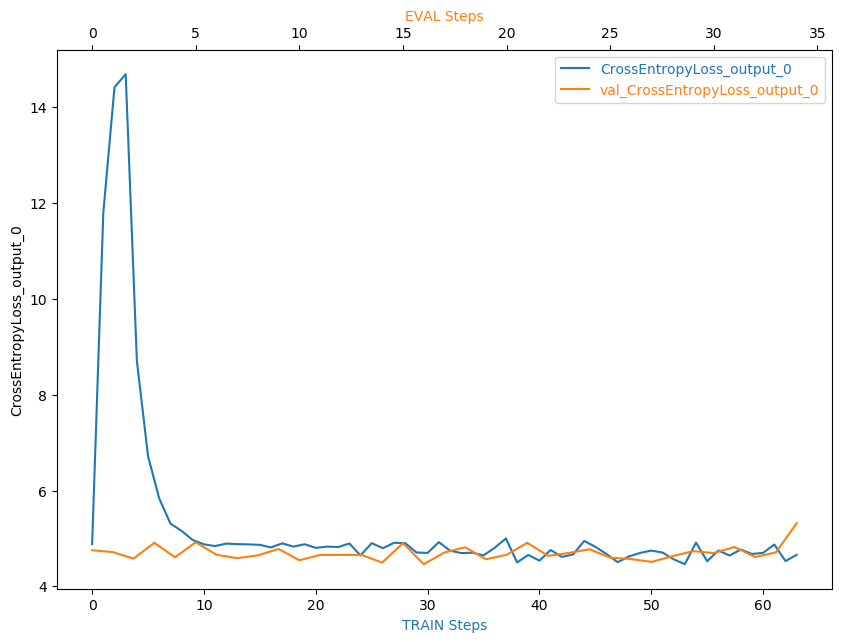

In [33]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [34]:
# TODO: Display the profiler output

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report path:  {rule_output_path}")

Profiler report path:  s3://sagemaker-us-east-1-733988231415/pytorch-training-2022-10-03-14-01-33-129/rule-output


In [35]:
! aws s3 ls {rule_output_path} --recursive

2022-10-03 14:12:20     364671 pytorch-training-2022-10-03-14-01-33-129/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-10-03 14:12:19     211729 pytorch-training-2022-10-03-14-01-33-129/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-10-03 14:12:14        191 pytorch-training-2022-10-03-14-01-33-129/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-10-03 14:12:14        199 pytorch-training-2022-10-03-14-01-33-129/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-10-03 14:12:14       1925 pytorch-training-2022-10-03-14-01-33-129/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-10-03 14:12:14        127 pytorch-training-2022-10-03-14-01-33-129/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-10-03 14:12:14        198 pytorch-training-2022-10-03-14-01-33-129/rule-output/ProfilerReport/profiler-output/profiler-re

In [36]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-733988231415/pytorch-training-2022-10-03-14-01-33-129/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-733988231415/pytorch-training-2022-10-03-14-01-33-129/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-733988231415/pytorch-training-2022-10-03-14-01-33-129/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-733988231415/pytorch-training-2022-10-03-14-01-33-129/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-733988231415/pytorch-training-2022-10-03-14-01-33-129/r

In [37]:
profiler_report_name = [rule["RuleConfigurationName"] for rule in estimator.latest_training_job.rule_job_summary()
                        if "Profiler" in rule["RuleConfigurationName"]
                       ][0]

print(profiler_report_name)
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

ProfilerReport


## Model Deploying

In [48]:
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [49]:
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-733988231415/pytorch-training-2022-10-03-14-01-33-129/output/model.tar.gz


In [50]:
from sagemaker.pytorch import PyTorchModel

pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [51]:
# TODO: Deploy your model to an endpoint

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large') # TODO: Add your deployment configuration like instance type and number of instances

------!

In [52]:
with open("endTest_2.jpg", "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)

type(img_bytes)

bytearray

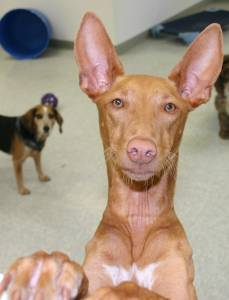

In [53]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [54]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [55]:
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(133), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Raw prediction result:
[[0.021170012652873993, -0.022215714678168297, 0.012376252561807632, 0.14389723539352417, 0.1176837608218193, -0.01816629245877266, 0.03101019188761711, 0.2218323051929474, -0.07860884815454483, -0.03652374818921089, 0.00039621395990252495, -0.145188108086586, 0.03510359674692154, 0.07084095478057861, 0.11145688593387604, 0.004159525036811829, 0.06527525186538696, -0.0020955237559974194, -0.004880477674305439, 0.14326836168766022, 0.14435701072216034, 0.06469034403562546, -0.08786936849355698, 0.09480694681406021, 0.01135812234133482, 0.008203735575079918, 0.019092489033937454, -0.008905386552214622, -0.1598975658416748, -0.014196510426700115, 0.031593725085258484, 0.09983374923467636, -0.1916951984167099, 0.08207396417856216, 0.10051922500133514, 0.038871996104717255, -0.04500703886151314, 0.19241860508918762, 0.018095361068844795, -0.025814343243837357, -0.016793400049209595, 0.06833527237176895, 0.04514889419078827, 0.0947914868593216, -0.18914760649204254, 0.

In [57]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()